In [1]:
%matplotlib inline
import sys, os, time, math, csv
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

### Load block group population estimates

In [2]:
county_fip_list = []
block_group_fip_list = []
bg_population_estimates = []

f = open("data/processed/regression_estimated_population.csv", "r")
predicted_years = list(map(int, f.readline().strip().split(",")[2:]))
num_block_groups = 0
num_years = len(predicted_years)

for line in f:
    line = line.strip()
    if line != "":
        parts = line.split(",")
        county_fips = parts[0]
        block_group_fips = parts[1]
        values = list(map(float,parts[2:]))
        
        county_fip_list.append(county_fips)
        block_group_fip_list.append(block_group_fips)
        bg_population_estimates.append(values)
        
        num_block_groups += 1
        assert len(values) == num_years
f.close()

bg_population_estimates = np.array(bg_population_estimates)
assert bg_population_estimates.shape[0] == num_block_groups
assert bg_population_estimates.shape[1] == num_years

### Aggregate population estimates at the county level

In [3]:
county_population_estimates = collections.OrderedDict()

for i in range(num_block_groups):
    county_fips = county_fip_list[i]
    
    if county_fips not in county_population_estimates:
        county_population_estimates[county_fips] = np.zeros(num_years).astype(float)
    
    county_population_estimates[county_fips] += bg_population_estimates[i, :]
    
county_fip_list_short = []
county_population_estimates_short = []
for k, v in county_population_estimates.items():
    county_fip_list_short.append(k)
    county_population_estimates_short.append(v)
county_population_estimates_short = np.array(county_population_estimates_short)
num_counties = len(county_fip_list_short)

In [4]:
county_population_estimates_short[:5,0]

array([ 54822.86792693, 184072.53361202,  27343.46188213,  22928.75913581,
        57413.2298351 ])

In [5]:
county_population_estimates_short[:5,-1]

array([111818.66502226, 384354.98159427,  43250.92497511,  37106.91868351,
       111885.7144422 ])

### Visualize population estimates

In [6]:
shapefileFn = "simple-maps/examples/cb_2015_us_county_500k/cb_2015_us_county_500k.shp"
shapefileKey = "GEOID"

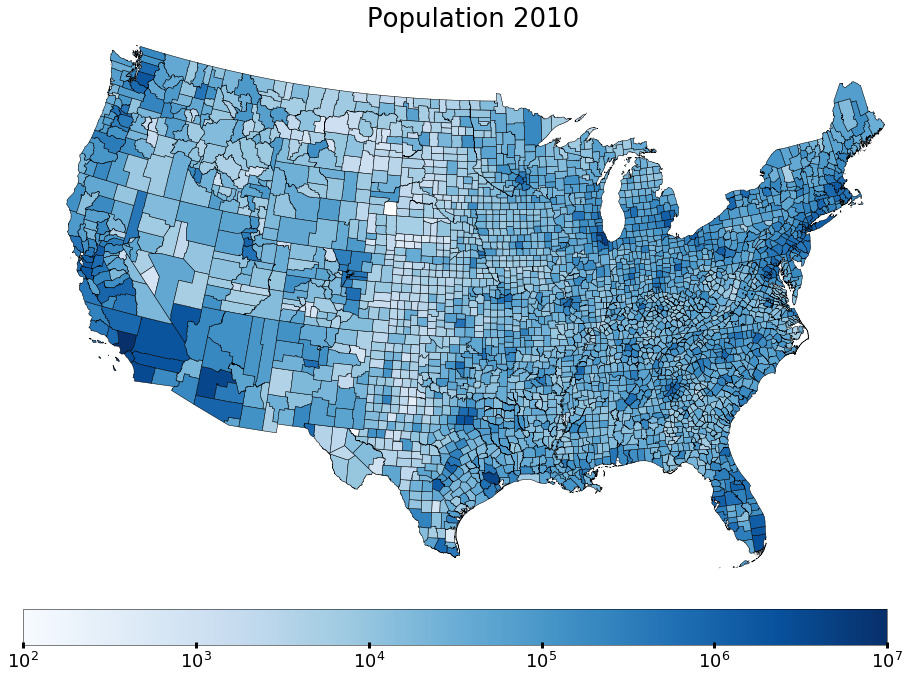

In [7]:
year_index = 0
year_1 = predicted_years[year_index]
pop_1 = {
    county_fip_list_short[i] : county_population_estimates_short[i, year_index]
    for i in range(num_counties)
}

simpleMap(
    shapefileFn,
    shapefileKey,
    pop_1,
    bounds=[22, 49, -119, -64],
    title="Population %d" % (year_1),
    colorbarRange=(1e2, 1e7),
    logScale=True,
)

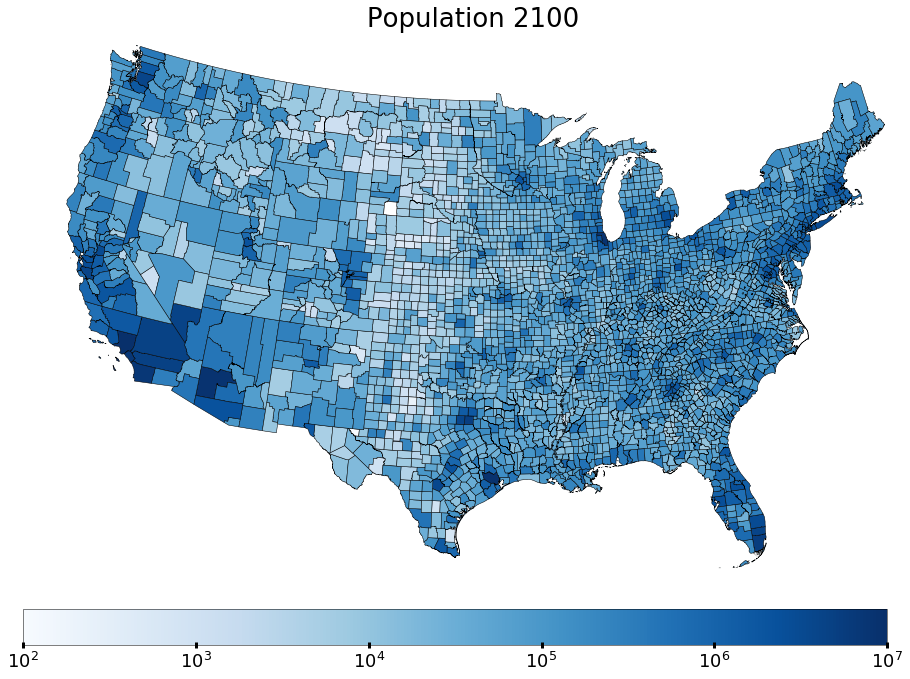

In [8]:
year_index = -1
year_2 = predicted_years[year_index]
pop_2 = {
    county_fip_list_short[i] : county_population_estimates_short[i, year_index]
    for i in range(num_counties)
}

simpleMap(
    shapefileFn,
    shapefileKey,
    pop_2,
    bounds=[22, 49, -119, -64],
    title="Population %d" % (year_2),
    colorbarRange=(1e2, 1e7),
    logScale=True,
)

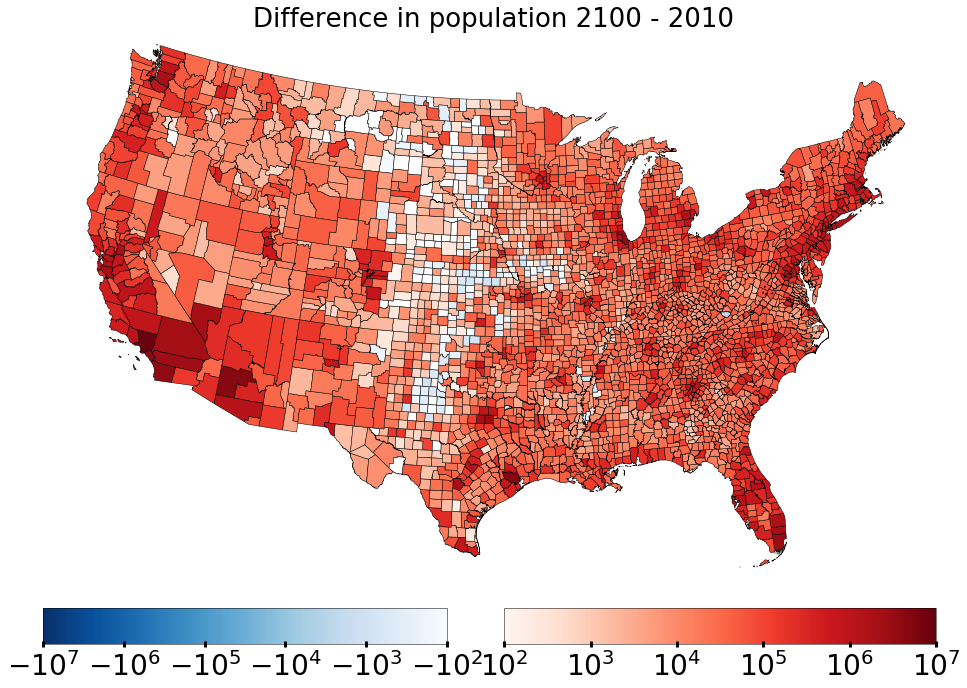

In [9]:
data_diff = {
    k: pop_2[k] - pop_1[k]
    for k in pop_1.keys()
}

differenceMap(
    shapefileFn,
    shapefileKey,
    data_diff,
    bounds=[22, 49, -119, -64],
    colorbarRange=(1e2, None),
    logScale=True,
    title="Difference in population %d - %d" % (year_2, year_1),
)

### Population of country

In [10]:
predicted_total_population = []

for i in range(county_population_estimates_short.shape[1]):
    predicted_total_population.append(np.sum(county_population_estimates_short[:,i]))

In [11]:
df = pd.read_csv("data/intermediate/national_population_projections_census_2012.csv")

In [12]:
df.columns

Index(['Year', 'Low', 'Middle', 'High'], dtype='object')

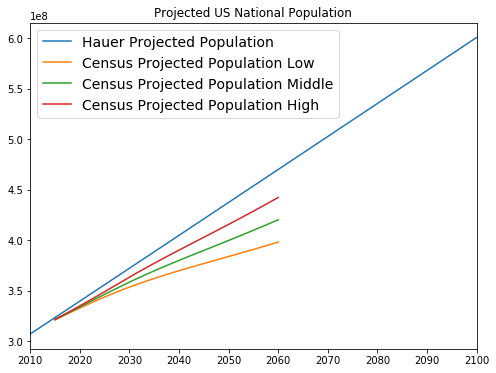

In [13]:
plt.figure(figsize=(8,6))

plt.plot(predicted_years, predicted_total_population, label="Hauer Projected Population")

plt.plot(df["Year"], df["Low"], label="Census Projected Population Low")
plt.plot(df["Year"], df["Middle"], label="Census Projected Population Middle")
plt.plot(df["Year"], df["High"], label="Census Projected Population High")

plt.legend(loc="best", fontsize=14)
plt.xlim([2010, 2100])
plt.title("Projected US National Population")

plt.show()
plt.close()

In [14]:
print("Estimated population in 2010 is:", predicted_total_population[0])

Estimated population in 2010 is: 307163692.088247
